In [1]:
# Standard Python modules
import os, sys
import numpy as np
import pandas as pd
import xarray as xr
import datetime as dt

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

# extras
%matplotlib inline
import metpy.calc as mpcalc
from metpy.units import units

# import personal modules
# Path to modules
sys.path.append('../modules')
import nclcmaps as nclc
from plotter import draw_basemap

pd.options.display.float_format = "{:,.2f}".format # makes it so pandas tables display only first two decimals

ERROR 1: PROJ: proj_create_from_database: Open of /cw3e/mead/projects/cwp140/scratch/dnash/miniconda3/envs/SEAK-clim/share/proj failed


In [2]:
# Set up paths

path_to_data = '/cw3e/mead/projects/cwp140/scratch/dnash/data/'      # project data -- read only
path_to_work = '/work/dnash/SEAK_clim_data/preprocessed/ERA5-IVT/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

## Load preprocessed 250Z and IVT data

In [3]:
community_lst = ['Hoonah', 'Skagway', 'Klukwan', 'Yakutat', 'Craig', 'Kasaan']
z250_lst = []
ivt_lst = []
for i, community in enumerate(community_lst):
    # open 250z data
    fname = path_to_data + 'preprocessed/ERA5_250Z_daily_{0}.nc'.format(community)
    z250 = xr.open_dataset(fname)
    # convert geopotential to geopotential height (m)
    z250 = z250.assign(z=lambda z250: z250['z']/(9.80665))
    z250_lst.append(z250)
    
    fname = path_to_data + 'preprocessed/ERA5_IVT_daily_{0}.nc'.format(community)
    ivt = xr.open_dataset(fname)
    ivt_lst.append(ivt)

z250_lst[0]


<xarray.Dataset>
Dimensions:  (lon: 281, lat: 245)
Coordinates:
  * lon      (lon) float32 -180.0 -179.8 -179.5 -179.2 ... -110.5 -110.2 -110.0
  * lat      (lat) float32 80.0 79.75 79.5 79.25 79.0 ... 19.75 19.5 19.25 19.0
    level    int32 ...
Data variables:
    z        (lat, lon) float32 9.743e+03 9.743e+03 ... 1.09e+04 1.09e+04

In [22]:
## merge all communities into single DS with "community name" as axis
ivt_comp = xr.concat(ivt_lst, dim=community_lst)
z250_comp = xr.concat(z250_lst, dim=community_lst)
## calculate average of all 6 communities
ivt_mean = ivt_comp.mean('concat_dim')
z250_mean = z250_comp.mean('concat_dim')

## subtract the mean from the original composites
ivt_diff = ivt_comp - ivt_mean
z250_diff = z250_comp - z250_mean
ivt_diff

<xarray.Dataset>
Dimensions:     (lat: 245, lon: 281, concat_dim: 6)
Coordinates:
  * lat         (lat) float64 19.0 19.25 19.5 19.75 ... 79.25 79.5 79.75 80.0
  * lon         (lon) float64 -180.0 -179.8 -179.5 ... -110.5 -110.2 -110.0
  * concat_dim  (concat_dim) object 'Hoonah' 'Skagway' ... 'Craig' 'Kasaan'
Data variables:
    IVT         (concat_dim, lat, lon) float64 -0.2493 -0.2757 ... -1.691 -1.67
    uIVT        (concat_dim, lat, lon) float64 2.891 2.841 ... -0.7396 -0.7438
    vIVT        (concat_dim, lat, lon) float64 3.266 3.439 ... -2.009 -2.023
    IWV         (concat_dim, lat, lon) float64 0.2511 0.2616 ... -0.2563 -0.2566

## Plot IVT and 250Z Composites

In [16]:
# Set up projection
# mapcrs = ccrs.Mercator()
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
lats = ivt_lst[0].lat.values
lons = ivt_lst[0].lon.values
dx = np.arange(lons.min().round(),lons.max().round()+20,20)
dy = np.arange(lats.min().round(),lats.max().round()+10,10)

# ext1 = [-141., -130., 54., 61.] # extent of SEAK
ext1 = [-180., -110., 19, 80] # extent of CIMSS Plots

# list of letters to append to titles
letter_lst = list(map(chr, range(97, 123)))

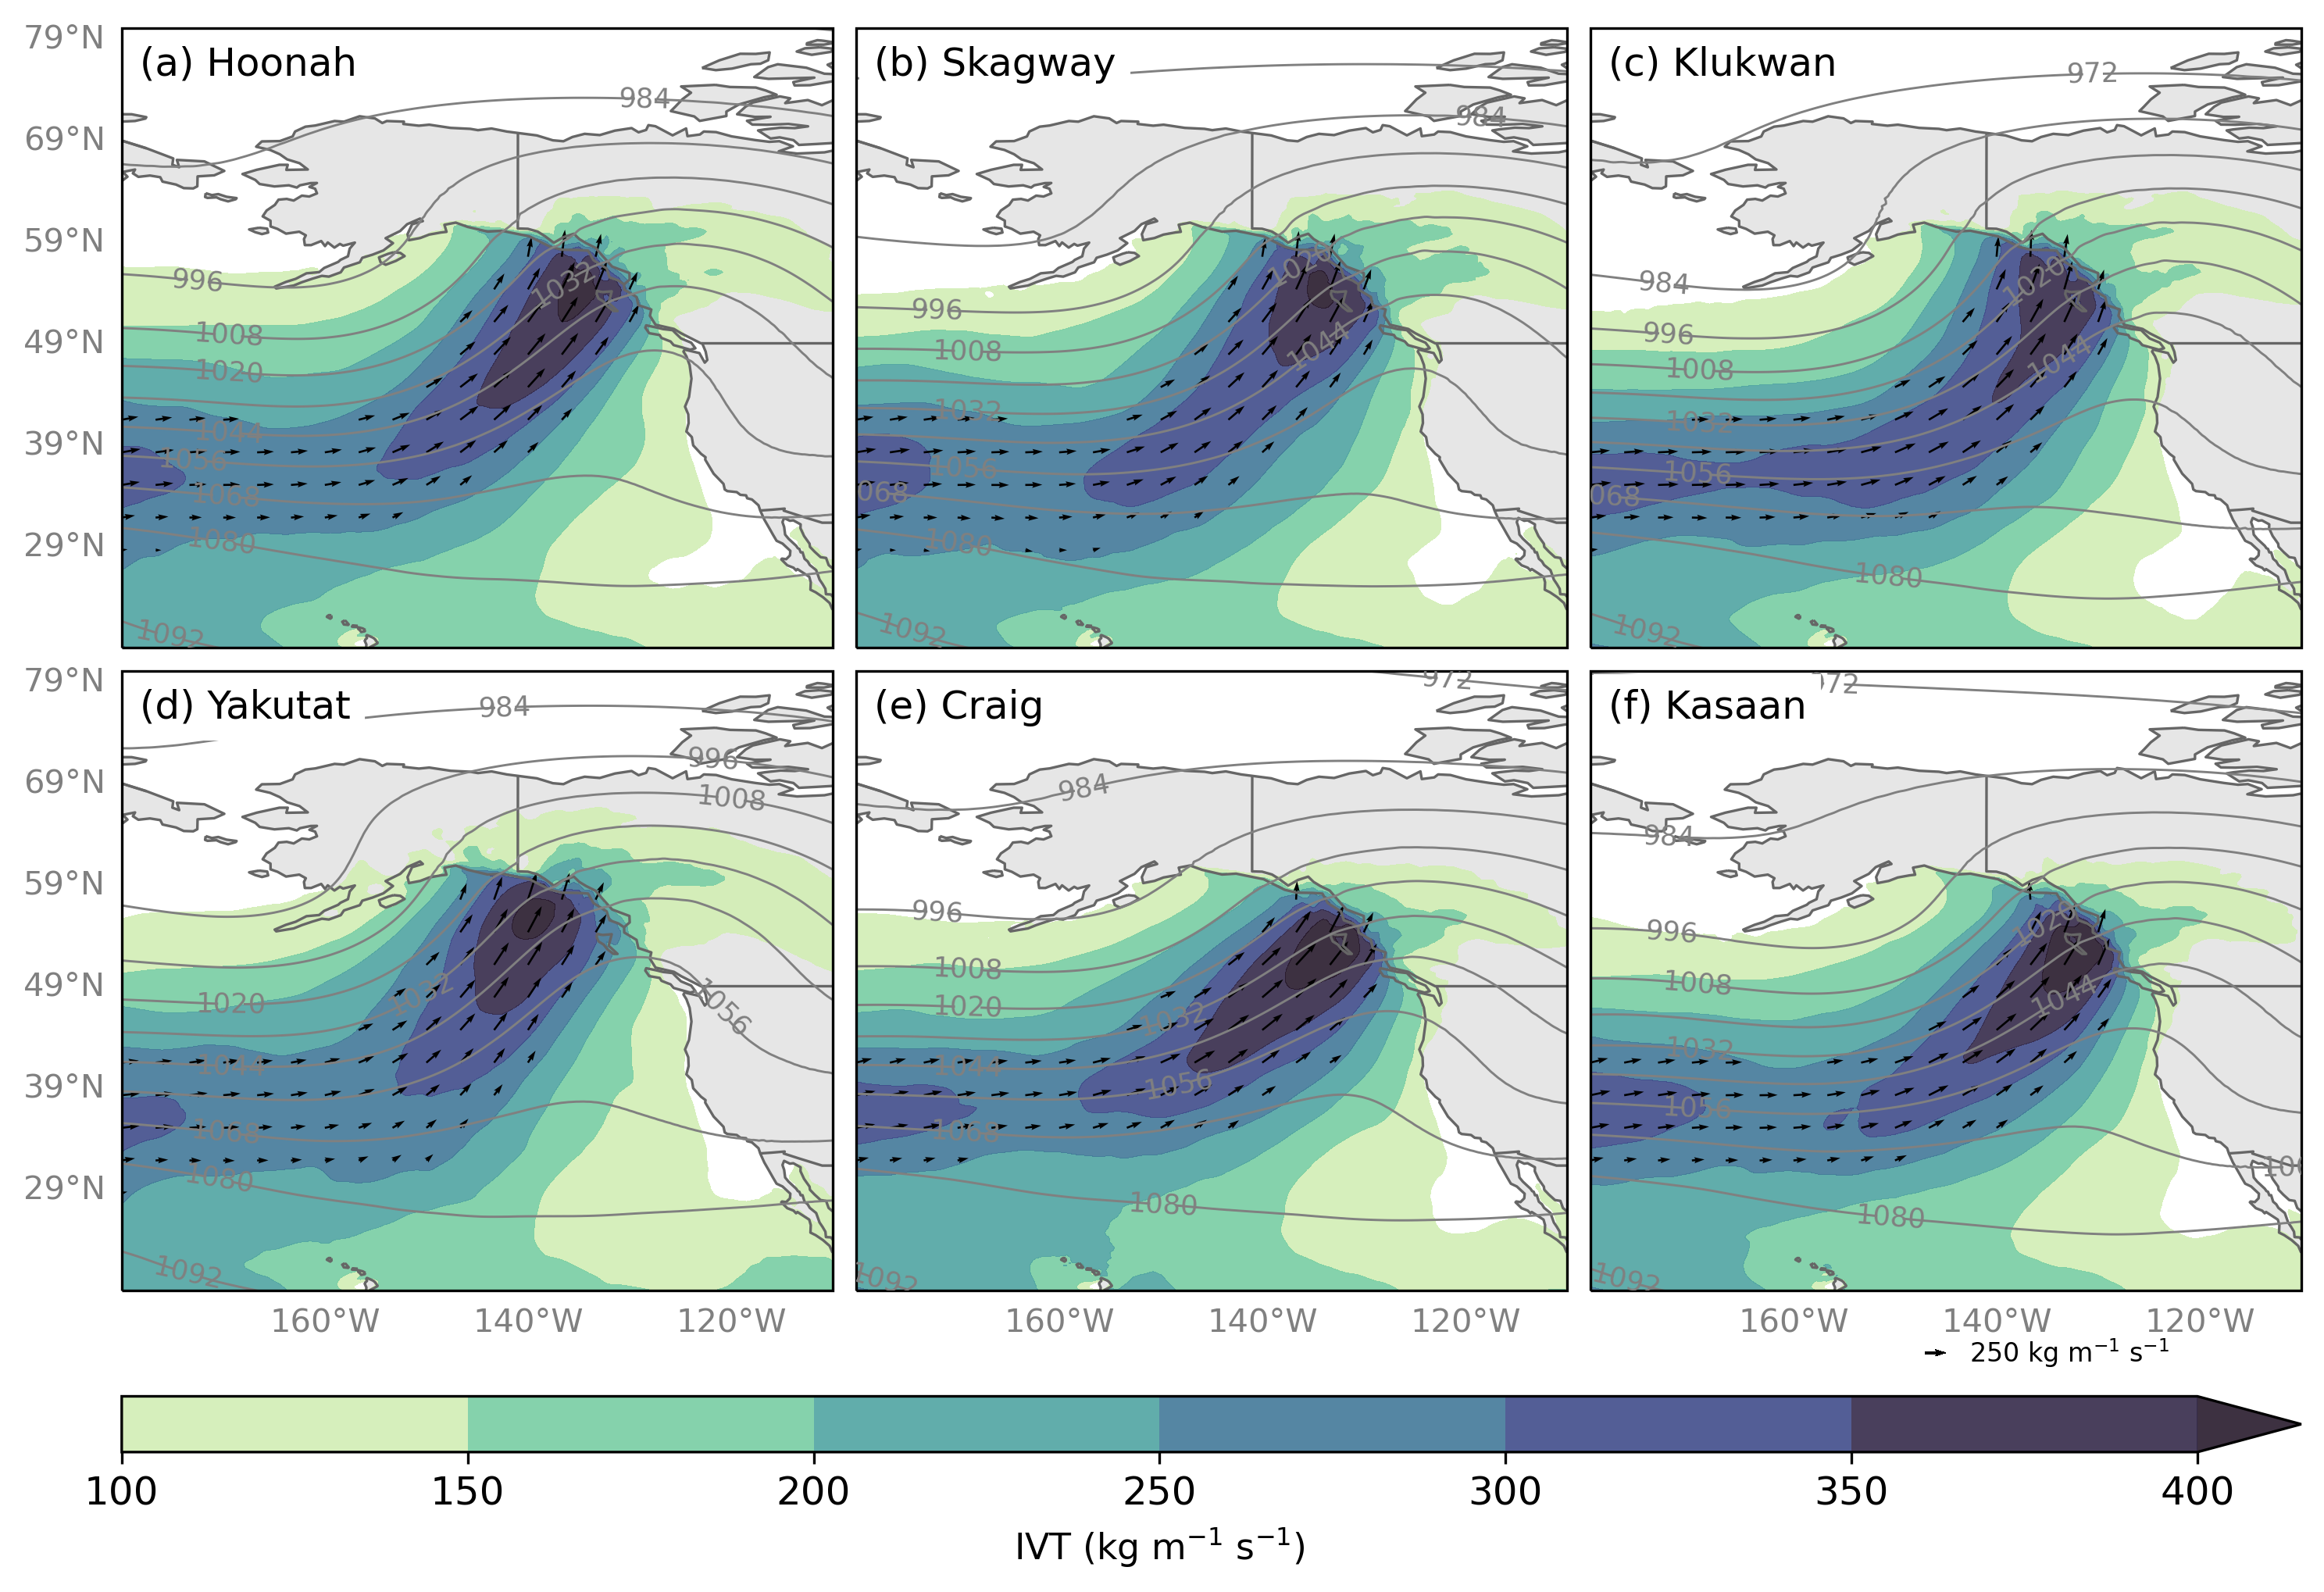

In [28]:
left_lat_lst = [True, False, False, True, False, False]
bottom_lon_lst = [False, False, False, True, True, True]
community = community_lst[i]
# Create figure
fig = plt.figure(figsize=(12, 8))
fig.dpi = 300
fname = path_to_figs + 'extreme-AR_IVT-250Z_composite_all'
fmt = 'png'

nrows = 2
ncols = 3

# Set up Axes Grid
axes_class = (GeoAxes,dict(projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.1,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.35, cbar_size='3%',label_mode='')


for k, ax in enumerate(axgr):
    ds = ivt_comp.sel(concat_dim=community_lst[k])
    data = z250_comp.sel(concat_dim=community_lst[k])
    ax = draw_basemap(ax, extent=ext1, xticks=dx, yticks=dy,left_lats=left_lat_lst[k], right_lats=False, bottom_lons=bottom_lon_lst[k])

    # Contour Filled
    lats = ds.lat.values
    lons = ds.lon.values
    ivt = ds.IVT.values
    cflevs = np.arange(100, 450, 50) # levels for IVT
    cmap = cmo.deep # cmap for IVT
    cf = ax.contourf(lons, lats, ivt, transform=datacrs,
                     levels=cflevs, cmap=cmap, alpha=0.9, extend='max')

    # Wind barbs / vectors 
    uvec = ds.uIVT.values
    vvec = ds.vIVT.values
    uvec_mask = ds.uIVT.where((ds.IVT >=250.)).values # mask values where IVT magnitude is less than 250 kg m-1 s-1
    vvec_mask = ds.vIVT.where((ds.IVT >=250.)).values # mask values where IVT magnitude is less than 250 kg m-1 s-1

    Q = ax.quiver(lons, lats, uvec_mask, vvec_mask, transform=datacrs, 
              color='k', regrid_shape=20,
              angles='xy', scale_units='xy', scale=125, units='xy')

    # ax.set_title(community_lst[k], loc='left', fontsize=10)
    titlestring = '({0}) {1}'.format(letter_lst[k], community_lst[k])
    ax.text(0.025, 0.9725, titlestring, ha='left', va='top', transform=ax.transAxes, fontsize=12., backgroundcolor='white', zorder=101)

    # Contour Lines
    lats = data.lat.values
    lons = data.lon.values
    hgts = data.z.values/(10) # convert to dekameters # 250-hPa Heights
    clevs = np.arange(696, 1280, 12)
    cs = ax.contour(lons, lats, hgts, transform=datacrs,
                    levels=clevs, colors='grey', linewidths=0.7)
    plt.clabel(cs, fmt='%d',fontsize=8.5, inline_spacing=5)


# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=False)
cb.set_label('IVT (kg m$^{-1}$ s$^{-1}$)', fontsize=11)
cb.ax.tick_params(labelsize=12)

# quiver key
qk = ax.quiverkey(Q, 0.5, -0.1, 250, '250 kg m$^{-1}$ s$^{-1}$', labelpos='E',
                  coordinates='axes', fontproperties={'size': 8.0})

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()

### Difference Composites

### Plot differences

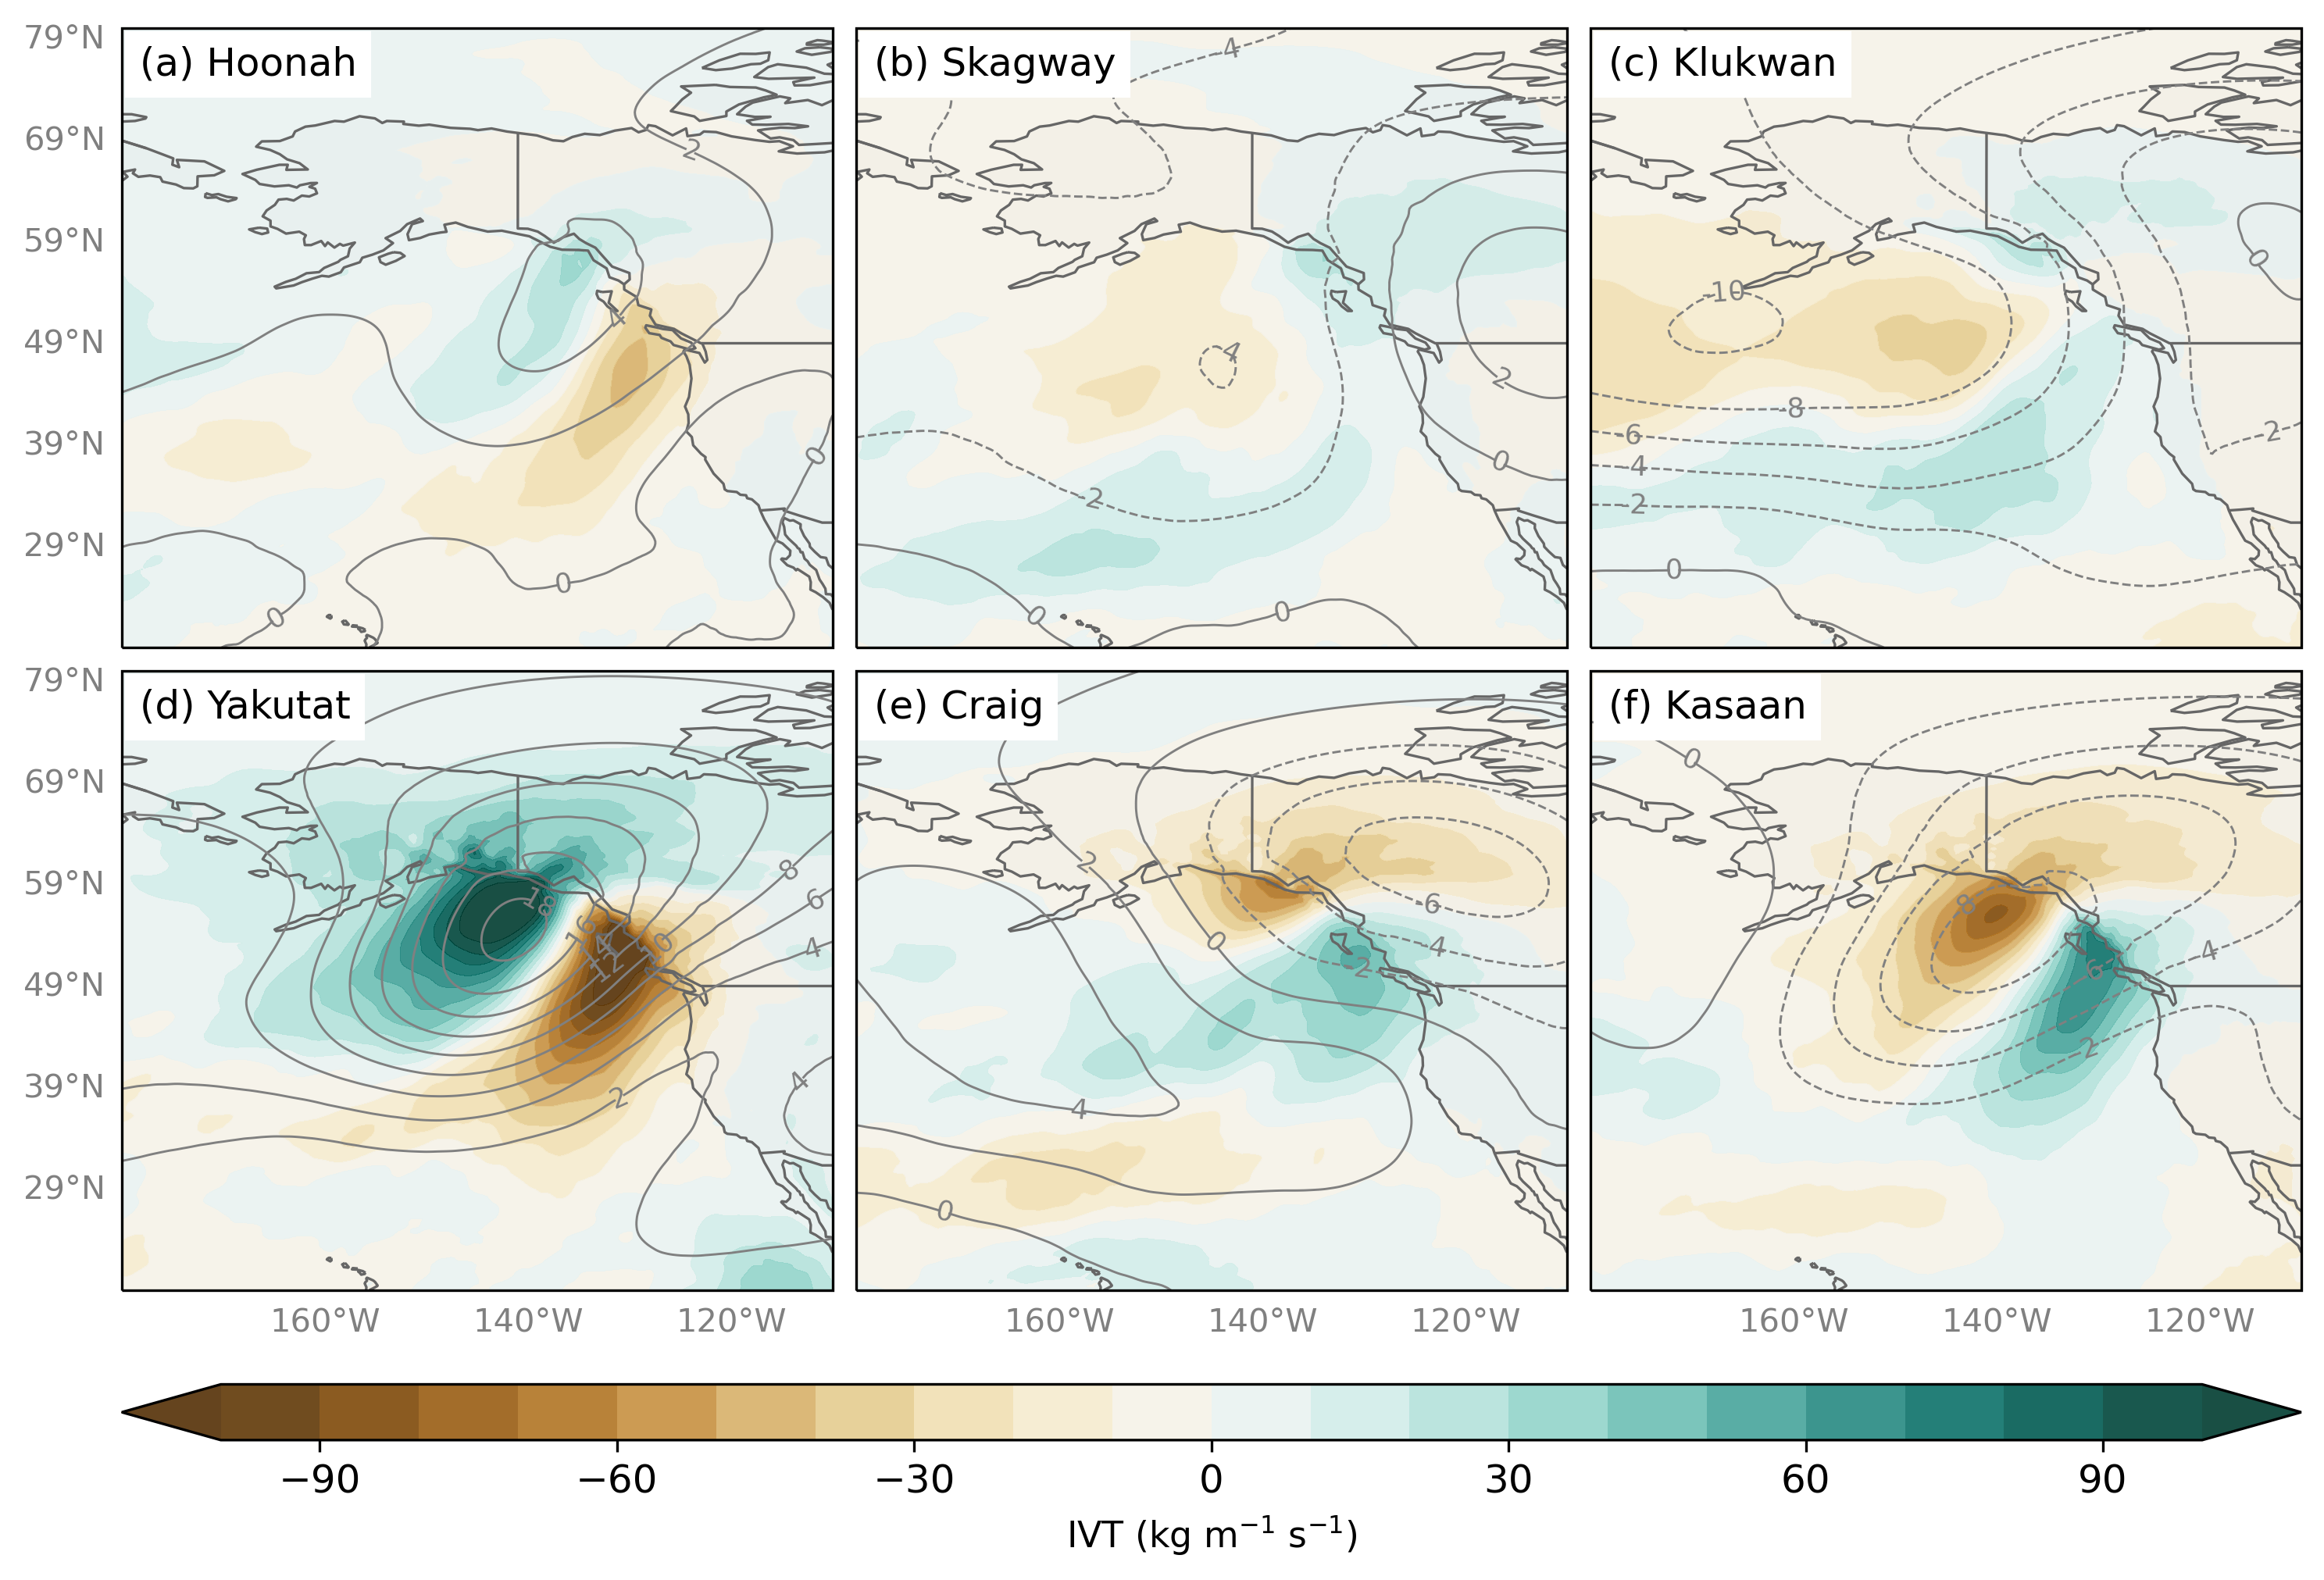

In [27]:
left_lat_lst = [True, False, False, True, False, False]
bottom_lon_lst = [False, False, False, True, True, True]
community = community_lst[i]
# Create figure
fig = plt.figure(figsize=(12, 8))
fig.dpi = 300
fname = path_to_figs + 'extreme-AR_IVT-250Z_composite_diff'
fmt = 'png'

nrows = 2
ncols = 3

# Set up Axes Grid
axes_class = (GeoAxes,dict(projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.1,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.3, cbar_size='3%',label_mode='')


for k, ax in enumerate(axgr):
    ds = ivt_diff.sel(concat_dim=community_lst[k])
    data = z250_diff.sel(concat_dim=community_lst[k])
    ax = draw_basemap(ax, extent=ext1, xticks=dx, yticks=dy,left_lats=left_lat_lst[k], right_lats=False, bottom_lons=bottom_lon_lst[k])

    # Contour Filled
    lats = ds.lat.values
    lons = ds.lon.values
    ivt = ds.IVT.values
    cflevs = np.arange(-100, 110, 10) # levels for IVT
    cmap = 'BrBG' # cmap for IVT
    cf = ax.contourf(lons, lats, ivt, transform=datacrs,
                     levels=cflevs, cmap=cmap, alpha=0.9, extend='both')


    # ax.set_title(community_lst[k], loc='left', fontsize=10)
    titlestring = '({0}) {1}'.format(letter_lst[k], community_lst[k])
    ax.text(0.025, 0.9725, titlestring, ha='left', va='top', transform=ax.transAxes, fontsize=12., backgroundcolor='white', zorder=101)

    # Contour Lines
    lats = data.lat.values
    lons = data.lon.values
    hgts = data.z.values/(10) # convert to dekameters # 250-hPa Heights
    clevs = np.arange(-20,22,2)
    cs = ax.contour(lons, lats, hgts, transform=datacrs,
                    levels=clevs, colors='grey', linewidths=0.7)
    plt.clabel(cs, fmt='%d',fontsize=8.5, inline_spacing=5)


# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=False)
cb.set_label('IVT (kg m$^{-1}$ s$^{-1}$)', fontsize=11)
cb.ax.tick_params(labelsize=12)


fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()

### Plot individual plots (for presentations and posters)

In [ ]:
for i, (ds, data) in enumerate(zip(ivt_lst, z250_lst)):
    community = community_lst[i]
    # Create figure
    fig = plt.figure(figsize=(8, 12))
    fig.dpi = 300
    fname = path_to_figs + 'extreme-AR_IVT-250Z_composite_{0}'.format(community)
    fmt = 'png'

    nrows = 1
    ncols = 1

    # Set up Axes Grid
    axes_class = (GeoAxes,dict(projection=mapcrs))
    axgr = AxesGrid(fig, 111, axes_class=axes_class,
                    nrows_ncols=(nrows, ncols), axes_pad = 0.45,
                    cbar_location='bottom', cbar_mode='single',
                    cbar_pad=0.05, cbar_size='3%',label_mode='')


    for k, ax in enumerate(axgr):
        ax = draw_basemap(ax, extent=ext1, xticks=dx, yticks=dy,left_lats=True, right_lats=False)

        # Contour Filled
        lats = ds.lat.values
        lons = ds.lon.values
        ivt = ds.IVT.values
        cflevs = np.arange(0, 550, 50) # levels for IVT
        cmap = cmo.deep # cmap for IVT
        cf = ax.contourf(lons, lats, ivt, transform=datacrs,
                         levels=cflevs, cmap=cmap, alpha=0.9, extend='max')

        # Wind barbs / vectors 
        uvec = ds.uIVT.values
        vvec = ds.vIVT.values
        uvec_mask = ds.uIVT.where((ds.IVT >=250.)).values # mask values where IVT magnitude is less than 250 kg m-1 s-1
        vvec_mask = ds.vIVT.where((ds.IVT >=250.)).values # mask values where IVT magnitude is less than 250 kg m-1 s-1
        
        Q = ax.quiver(lons, lats, uvec_mask, vvec_mask, transform=datacrs, 
                  color='k', regrid_shape=20,
                  angles='xy', scale_units='xy', scale=125, units='xy')
        
        # ax.set_title(community, loc='left')
        
        # Contour Lines
        lats = data.lat.values
        lons = data.lon.values
        hgts = data.z.values/(10) # convert to dekameters # 250-hPa Heights
        clevs = np.arange(696, 1280, 12)
        cs = ax.contour(lons, lats, hgts, transform=datacrs,
                        levels=clevs, colors='grey', linewidths=0.7)
        plt.clabel(cs, fmt='%d',fontsize=8.5, inline_spacing=5)


    # Colorbar (single)
    cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=False)
    cb.set_label('IVT (kg m$^{-1}$ s$^{-1}$)', fontsize=11)
    cb.ax.tick_params(labelsize=12)
    
    # quiver key
    qk = ax.quiverkey(Q, 0.8, -0.05, 250, '250 kg m$^{-1}$ s$^{-1}$', labelpos='E',
                      coordinates='axes', fontproperties={'size': 8.0})

    fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

    # Show
    plt.show()